<a href="https://colab.research.google.com/github/mkcifci/STT/blob/main/two_staged_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First stage: Classify for economic globalization (trade, foreign investment and immigration)


## Default parameters

In [ ]:
# %%capture
# !pip install transformers
# !pip install simpletransformers

In [3]:
%%capture
!pip install transformers
!pip install simpletransformers==0.63.7

In [4]:
import random
import pandas as pd 
import numpy as np 
import torch
import os

In [5]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value) # gpu vars
    torch.backends.cudnn.deterministic = True  #needed
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed_value)

In [6]:
seed_all(4) # original seed

# seed_all(5) # gave save results for first stage roberta tuned

# seed_all(6)

# seed_all(7) 

# seed_all(8) # gave save results for first stage roberta tuned

# seed_all(9)

# seed_all(10) # gave save results for first stage roberta tuned

# seed_all(11)

# seed_all(1111) # gave different results for first stage roberta tuned


In [7]:
#Connect Google Drive
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive')

Mounted at /content/drive


In [2]:
# get GPU information 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Oct 12 15:55:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [9]:
from sklearn.model_selection import train_test_split
import pandas as pd 

import sys
train_df = pd.read_excel("train_march.xlsx")
test_df = pd.read_excel("test_march.xlsx")

train_df = train_df[train_df['globalization'].notnull()]
test_df = test_df[test_df['globalization'].notnull()]


train_new_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

print(len(test_df), len(train_new_df), len(val_df))

train_new_df = train_new_df[["body", "globalization"]]
val_df = val_df[["body", "globalization"]]
test_df = test_df[["body", "globalization"]]

443 1400 350


In [10]:
train_new_df.head()

,body,globalization
414,Senators to Special Inspector General Miller: ...,0.0
199,"Washington, D.C. Today, Representatives Rick ...",0.0
1706,Senator Hirono Discusses Justin Walker's Nomin...,0.0
72,"Wednesday | January 8, 2020\n\t\t\t Senator Sc...",0.0
549,"In 2018, our security can no longer exclusivel...",0.0


In [11]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# use this for initial run
train_args = {
    "output_dir": "final_outputs/step1_bert_default",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,
    
    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,  
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,

}

In [12]:
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, classification_report

In [ ]:
# Create a ClassificationModel
model = ClassificationModel(
    "bert", "bert-base-uncased", args=train_args, use_cuda=True, num_labels=2
    )

In [ ]:
model.train_model(train_new_df, eval_df=val_df, f1=sklearn.metrics.f1_score)

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(val_df, verbose=True, f1=sklearn.metrics.f1_score)

In [ ]:
model = ClassificationModel(
    "bert", "final_outputs/step1_bert_default"
)

In [ ]:
predictions, raw_outputs = model.predict(test_df["body"].tolist())

In [ ]:
print(classification_report(test_df["globalization"], 
                            predictions))

print(confusion_matrix(test_df["globalization"], predictions))

print(f1_score(test_df["globalization"], predictions))

In [ ]:
# use this for initial run
train_args = {
    "output_dir": "final_outputs/step1_roberta_default",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,
    
    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,  
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,

}

In [ ]:
model2 = ClassificationModel(
    "roberta", "roberta-base", args=train_args, use_cuda=True,num_labels=2)

In [ ]:
model2.train_model(train_new_df, eval_df=val_df, f1=sklearn.metrics.f1_score)

In [ ]:
result2, model2_outputs, wrong_predictions2 = model2.eval_model(val_df, verbose=True, f1=sklearn.metrics.f1_score)

In [ ]:
model2 = ClassificationModel(
    "roberta", "final_outputs/step1_roberta_default"
)

In [ ]:
predictions2, raw_outputs2 = model2.predict(test_df.body.tolist())

In [ ]:
print(classification_report(test_df["globalization"], 
                            predictions2))

print(confusion_matrix(test_df["globalization"], predictions2))

print(f1_score(test_df["globalization"], predictions2))

In [ ]:
# use this for initial run
train_args = {
    "output_dir": "final_outputs/step1_distilbert_default",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,
    
    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,  
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,

}

In [ ]:
model3 = ClassificationModel(
    "distilbert", "distilbert-base-uncased", args=train_args, use_cuda=True,num_labels=2)

In [ ]:
model3.train_model(train_new_df, eval_df=val_df, f1=sklearn.metrics.f1_score)

In [ ]:
result3, model3_outputs, wrong_predictions3 = model3.eval_model(val_df, verbose=True, f1=sklearn.metrics.f1_score)

In [ ]:
model3 = ClassificationModel(
    "distilbert", "final_outputs/step1_distilbert_default"
)

In [ ]:
predictions3, raw_outputs3 = model3.predict(test_df.body.tolist())

In [ ]:
print(classification_report(test_df["globalization"], 
                            predictions3))

print(confusion_matrix(test_df["globalization"], predictions3))

print(f1_score(test_df["globalization"], predictions3))

## *Hyperparameter* tuning RoBERTa



In [ ]:
train_args = {
    "output_dir": "final_outputs/step1_tuning",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    "wandb_project" : "eco-glob-aug", # uncomment for hyperparameter tuning
    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,

}

In [ ]:
import wandb 

sweep_config = {
    "method": "random",  # grid, random (pick random variable for every hyperparameter), bayes
    "metric": {"name": "f1", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 2, "max": 5}, 
        "learning_rate": {"min": 2e-5, "max": 5e-5},
        },
    "early_terminate": {"type": "hyperband", "min_iter":3,},
}
sweep_id = wandb.sweep(sweep_config, project="economic_globalization_step1")

In [ ]:
def train():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "roberta",
        "roberta-base",
        use_cuda=True,
        args=train_args,
        sweep_config=wandb.config,
    )
  
    # Train the model
    model.train_model(
        train_new_df,
        eval_df=val_df,
        f1=sklearn.metrics.f1_score)

    # Sync wandb
    wandb.join()

wandb.agent(sweep_id, train)

In [ ]:
# use this from random search
train_args = {
#    "output_dir": "final_outputs/step1_roberta_tuned",

#    "output_dir": "final_outputs/step1_seed5_roberta_tuned",
#    "output_dir": "final_outputs/step1_seed6_roberta_tuned",
    "output_dir": "final_outputs/step1_seed7_roberta_tuned",
#    "output_dir": "final_outputs/step1_seed8_roberta_tuned",

#    "output_dir": "final_outputs/step1_seed9_roberta_tuned",

#    "output_dir": "final_outputs/step1_seed10_roberta_tuned",
#    "output_dir": "final_outputs/step1_seed11_roberta_tuned",

#    "output_dir": "final_outputs/step1_seed1111_roberta_tuned",

    'max_seq_length': 512,
    'num_train_epochs': 2,
    'train_batch_size': 16,
    'eval_batch_size': 20,
    'gradient_accumulation_steps': 1,
    'learning_rate': 0.00002878, # 5e-5
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False
}

In [ ]:
model4 = ClassificationModel(
    "roberta", "roberta-base", args=train_args, use_cuda=True,num_labels=2)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model4.train_model(train_new_df, eval_df=val_df, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Running Epoch 0 of 2:   0%|          | 0/88 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 2:   0%|          | 0/88 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


(176,
 defaultdict(list,
             {'global_step': [88, 176],
              'train_loss': [0.4819221496582031, 0.029930591583251953],
              'mcc': [0.3019661816813715, 0.7544758625357304],
              'tp': [5, 37],
              'tn': [302, 293],
              'fp': [0, 9],
              'fn': [43, 11],
              'auroc': [0.950055187637969, 0.9675772626931568],
              'auprc': [0.8363388335977754, 0.8657177588548581],
              'f1': [0.18867924528301885, 0.7872340425531915],
              'eval_loss': [0.2451107038391961, 0.15247939547730816]}))

In [ ]:
result4, model4_outputs, wrong_predictions4 = model4.eval_model(val_df, verbose=True, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
model4 = ClassificationModel(
    "roberta", "final_outputs/step1_seed_roberta_tuned"
)

In [ ]:
predictions4, raw_outputs4 = model4.predict(test_df.body.tolist())

  0%|          | 0/23 [00:00<?, ?it/s]

In [ ]:
print(classification_report(test_df["globalization"], 
                            predictions4))

print(confusion_matrix(test_df["globalization"], predictions4))

print(f1_score(test_df["globalization"], predictions4))

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98       396
         1.0       0.78      0.83      0.80        47

    accuracy                           0.96       443
   macro avg       0.88      0.90      0.89       443
weighted avg       0.96      0.96      0.96       443

[[385  11]
 [  8  39]]
0.8041237113402062


In [ ]:
### seeed 1111
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.98       396
         1.0       0.80      0.79      0.80        47

    accuracy                           0.96       443
   macro avg       0.89      0.88      0.89       443
weighted avg       0.96      0.96      0.96       443

[[387   9]
 [ 10  37]]
0.795698924731183


## Apply tuned-RoBERTA on corpus

In [ ]:
predictions_1_final = pd.DataFrame(predictions4)
predictions4_1 = pd.DataFrame(raw_outputs4)

import tensorflow as tf
import tensorflow_datasets as tfds
predictions4_2 = tf.math.softmax(predictions4_1, axis=-1) # last dimension #

ds_numpy = tfds.as_numpy(predictions4_2)  # Convert `tf.data.Dataset` to numpy then to pandas
ds_pandas = pd.DataFrame(ds_numpy, columns = ['0','1']) 

test_df['prediction_1'] = ds_pandas[ds_pandas.columns[1]].values

0.8768353330628536


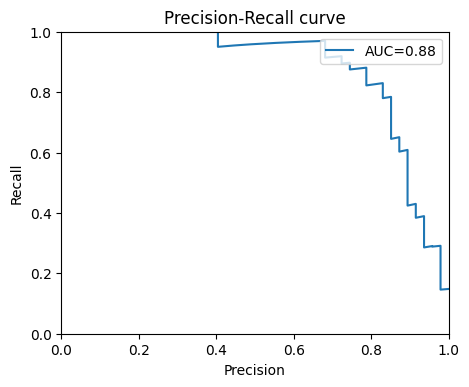

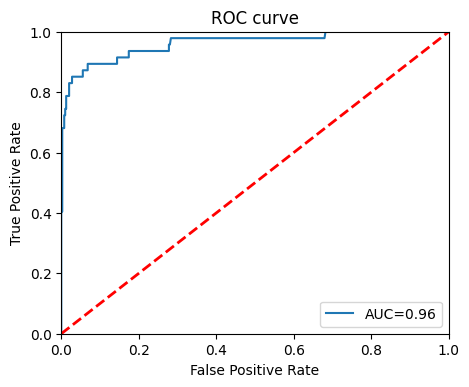

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(test_df["globalization"], test_df['prediction_1'])
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

plt.figure(figsize=(5,4), dpi=100)
plt.plot(recall, precision, label="AUC="+str(round(auc_precision_recall,2)))
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend(loc=1)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall curve")
plt.savefig('pr_curve.png', bbox_inches='tight')
plt.show()

from sklearn import metrics
plt.figure(figsize=(5,4), dpi=100)
fpr, tpr, _ = metrics.roc_curve(test_df["globalization"], test_df['prediction_1'])
auc = metrics.roc_auc_score(test_df["globalization"], test_df['prediction_1'])
plt.plot(fpr,tpr,label="AUC="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.ylim([0, 1])
plt.xlim([0, 1])

plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.savefig('ROC_curve.png', bbox_inches='tight')
plt.show()

In [ ]:
# corpus
universe_df = pd.read_csv("search_universe.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
universe_df.head() # change rest_documents below to universe_df

,member_id,congress_id,url,date,title,body,state,party,fec_candidate_id,date2,date3
0,A000360,113,https://www.alexander.senate.gov/public/index....,2014-09-11,"2014 National Franchisee Association ""King of ...","[Sept. 11, 2014] Senator Alexander received th...",TN,R,NaN,2014/09,2014
1,A000360,113,https://www.alexander.senate.gov/public/index....,2014-09-18,"National Federation of Independent Business ""G...",Senator Alexander received the National Federa...,TN,R,NaN,2014/09,2014
2,A000360,113,https://www.alexander.senate.gov/public/index....,2014-09-09,Alexander: No Tennessean Should Have to Ask Co...,U.S. Senator Lamar Alexander (R-Tenn.) today a...,TN,R,NaN,2014/09,2014
3,A000360,113,https://www.alexander.senate.gov/public/index....,2014-09-16,Alexander discusses Ebola with CNN's Wolf Blitzer,Senator Alexander joins CNN's Wolf Blitzer to ...,TN,R,NaN,2014/09,2014
4,A000360,113,https://www.alexander.senate.gov/public/index....,2014-09-16,Alexander says Threat of Ebola Must be Taken a...,In a joint hearing today between the Senate He...,TN,R,NaN,2014/09,2014


### apply model to set in batches

In [ ]:
len(universe_df)

539898

#### Batch 1

In [ ]:
batch_1 = universe_df[0:70000]

In [ ]:
batch1, batch1_outputs1 = model4.predict(batch_1.body.tolist())

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch1 = pd.DataFrame(batch1)

In [ ]:
batch_1['prediction_final'] = predictions_final_batch1.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
batch_1.to_excel('step1_batch_1_seed5.xlsx') # export to excel

#### Batch 2

In [ ]:
batch_2 = universe_df[70000:100000]

In [ ]:
batch2, batch2_outputs1 = model4.predict(batch_2.body.tolist())

  0%|          | 0/1500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch2 = pd.DataFrame(batch2)

In [ ]:
batch_2['prediction_final'] = predictions_final_batch2.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
batch_2.to_excel('step1_batch_2_seed5.xlsx') # export to excel

#### Batch 3

In [ ]:
batch_3 = universe_df[100000:150000]

In [ ]:
batch3, batch3_outputs1 = model4.predict(batch_3.body.tolist())

  0%|          | 0/2500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch3 = pd.DataFrame(batch3)

In [ ]:
batch_3['prediction_final'] = predictions_final_batch3.values

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
batch_3.to_excel('step1_batch_3_seed5.xlsx') # export to excel

#### Batch 4

In [ ]:
batch_4 = universe_df[150000:220000]

In [ ]:
batch4, batch4_outputs1 = model4.predict(batch_4.body.tolist())

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch4 = pd.DataFrame(batch4)
batch_4['prediction_final'] = predictions_final_batch4.values
batch_4.to_excel('step1_batch_4_seed5.xlsx') # export to excel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Batch 5

In [ ]:
batch_5 = universe_df[220000:290000]

In [ ]:
batch5, batch5_outputs1 = model4.predict(batch_5.body.tolist())

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch5 = pd.DataFrame(batch5)
batch_5['prediction_final'] = predictions_final_batch5.values
batch_5.to_excel('step1_batch_5_seed5.xlsx') # export to excel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Batch 6

In [ ]:
batch_6 = universe_df[290000:360000]

In [ ]:
batch6, batch6_outputs1 = model4.predict(batch_6.body.tolist())

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch6 = pd.DataFrame(batch6)
batch_6['prediction_final'] = predictions_final_batch6.values
batch_6.to_excel('step1_batch_6_seed5.xlsx') # export to excel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Batch 7

In [ ]:
batch_7 = universe_df[360000:430000]

In [ ]:
batch7, batch7_outputs1 = model4.predict(batch_7.body.tolist())

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch7 = pd.DataFrame(batch7)
batch_7['prediction_final'] = predictions_final_batch7.values
batch_7.to_excel('step1_batch_7_seed5.xlsx') # export to excel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Batch 8

In [ ]:
batch_8 = universe_df[430000:500000]

In [ ]:
batch8, batch8_outputs1 = model4.predict(batch_8.body.tolist())

  0%|          | 0/3500 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch8 = pd.DataFrame(batch8)
batch_8['prediction_final'] = predictions_final_batch8.values
batch_8.to_excel('step1_batch_8_seed5.xlsx') # export to excel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Batch 9

In [ ]:
batch_9 = universe_df[500000:539898]

In [ ]:
batch9, batch9_outputs1 = model4.predict(batch_9.body.tolist())

  0%|          | 0/1995 [00:00<?, ?it/s]

In [ ]:
predictions_final_batch9 = pd.DataFrame(batch9)
batch_9['prediction_final'] = predictions_final_batch9.values
batch_9.to_excel('step1_batch_9_seed5.xlsx') # export to excel

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


# Second stage: Classify for protectionism

### Finalize the batches and prepare it for classification

In [ ]:
# read in the batches
batch_1 = pd.read_excel("step1_batch_1.xlsx")

In [ ]:
batch_1 = batch_1.loc[batch_1['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_2 = pd.read_excel("step1_batch_2.xlsx")

In [ ]:
batch_2 = batch_2.loc[batch_2['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_3 = pd.read_excel("step1_batch_3.xlsx")

In [ ]:
batch_3 = batch_3.loc[batch_3['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_4 = pd.read_excel("step1_batch_4.xlsx")

In [ ]:
batch_4 = batch_4.loc[batch_4['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_5 = pd.read_excel("step1_batch_5.xlsx")

In [ ]:
batch_5 = batch_5.loc[batch_5['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_6 = pd.read_excel("step1_batch_6.xlsx")

In [ ]:
batch_6 = batch_6.loc[batch_6['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_7 = pd.read_excel("step1_batch_7.xlsx")

In [ ]:
batch_7 = batch_7.loc[batch_7['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_8 = pd.read_excel("step1_batch_8.xlsx")

In [ ]:
batch_8 = batch_8.loc[batch_8['prediction_final'] == 1]

In [ ]:
# read in the batches
batch_9 = pd.read_excel("step1_batch_9.xlsx")

In [ ]:
batch_9 = batch_9.loc[batch_9['prediction_final'] == 1]

In [ ]:
eco_glob_documents = pd.concat([batch_1, batch_2,batch_3,batch_4,batch_5,batch_6,batch_7,batch_8,batch_9])

In [ ]:
len(eco_glob_documents)

55832

In [ ]:
eco_glob_documents

In [ ]:
eco_glob_documents.to_excel('step1_eco_glob_documents_see7.xlsx') # export to excel

In [ ]:
# eco_glob_documents = pd.read_excel("step1_eco_glob_documents.xlsx")

In [ ]:
for col in eco_glob_documents.columns:
  print(col)

Unnamed: 0
member_id
congress_id
url
date
title
body
state
party
fec_candidate_id
date2
date3
prediction_final


In [ ]:
eco_glob_documents.drop('Unnamed: 0', axis=1, inplace=True)
# eco_glob_documents.drop('Unnamed: 0.1', axis=1, inplace=True)

In [ ]:
# eco_glob_documents.drop('globalization', axis=1, inplace=True) 
eco_glob_documents.drop('prediction_final', axis=1, inplace=True)

In [ ]:
import numpy as np
eco_glob_documents["stance"] = np.nan

In [ ]:
from sklearn.model_selection import train_test_split

sample, rest_corpus = train_test_split(eco_glob_documents,test_size=0.9596, random_state=4)  

In [ ]:
len(rest_corpus)

53577

In [ ]:
len(sample)

2255

In [ ]:
# sample.to_excel('step2_stance_labeling_new.xlsx') # export to excel

In [27]:
import pandas as pd
sample_labeled1 = pd.read_excel('step2_stance_labeling.xlsx')

In [29]:
sample_labeled2 = pd.read_excel('step2_stance_labeling_new_oct4.xlsx')

In [ ]:
sample_labeled.head()

In [15]:
len(sample_labeled)

2255

In [30]:
sample_labeled_not1 = sample_labeled1[sample_labeled1['stance'].isna()]

In [31]:
sample_labeled_not2 = sample_labeled2[sample_labeled2['stance'].isna()]

In [17]:
len(sample_labeled_not)

2054

In [ ]:
eco_glob_documents = pd.concat([rest_corpus, sample_labeled_not])

In [ ]:
len(eco_glob_documents)

In [32]:
sample_labeled1 = sample_labeled1[sample_labeled1['stance'].notna()]

In [33]:
sample_labeled2 = sample_labeled2[sample_labeled2['stance'].notna()]

In [36]:
len(sample_labeled2)

201

In [37]:
sample_labeled = pd.concat([sample_labeled1, sample_labeled2])

In [38]:
len(sample_labeled)

1000

In [39]:
from sklearn.model_selection import train_test_split

training_val_stance, test_stance = train_test_split(sample_labeled, test_size=0.2, random_state=4)

train_stance, val_stance = train_test_split(training_val_stance, test_size=0.2, random_state=4)

In [40]:
print(len(train_stance), len(val_stance), len(test_stance))

640 160 200


In [43]:
train_stance = train_stance[["body", "stance"]]
val_stance = val_stance[["body", "stance"]]
test_stance = test_stance[["body", "stance"]]

In [44]:
sample_labeled['stance'].value_counts()

1.0    522
0.0    478
Name: stance, dtype: int64

In [45]:
type(val_stance.stance)

pandas.core.series.Series

In [46]:
test_stance['stance'].value_counts()

1.0    114
0.0     86
Name: stance, dtype: int64

In [47]:
test_stance.head()

,body,stance
698,"August 27, 2014\n\t\t\t Cardin, Wyden, Brown C...",1.0
577,Congressman Andy Levin (D-MI-09) and Congressm...,0.0
763,Click here or on the picture above to watch Th...,1.0
790,Kaine And Menendez Meet With Central American ...,0.0
520,06.26.20\n\t\t\t Statement On The Inter-Americ...,0.0



### Default parameters

In [48]:
# use this for initial run
train_args = {
    "output_dir": "final_outputs/step2_bert_default",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,  
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,

}

In [49]:
# Create a ClassificationModel
model5 = ClassificationModel(
    "bert", "bert-base-uncased", args=train_args, use_cuda=True,num_labels=2
    )

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [50]:
model5.train_model(train_stance, eval_df=val_stance, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 5:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


(200,
 defaultdict(list,
             {'global_step': [40, 80, 120, 160, 200],
              'train_loss': [0.6942596435546875,
               0.4788818359375,
               0.4627952575683594,
               0.2242898941040039,
               0.05890226364135742],
              'mcc': [0.09435092510646935,
               0.2722690052992871,
               0.43638265701241585,
               0.39077326471221924,
               0.4629023125327431],
              'tp': [79, 32, 45, 30, 62],
              'tn': [5, 67, 68, 75, 55],
              'fp': [74, 12, 11, 4, 24],
              'fn': [2, 49, 36, 51, 19],
              'auroc': [0.5870448507579309,
               0.7030786060321925,
               0.7762931708079387,
               0.7834036568213784,
               0.78965463353649],
              'auprc': [0.5740897526317751,
               0.6955629447275481,
               0.7405181813404614,
               0.7989773523090096,
               0.8022803595875864],
              

In [51]:
model5 = ClassificationModel(
    "bert", "final_outputs/step2_bert_default"
)

In [52]:
result5, model5_outputs, wrong_predictions5 = model5.eval_model(val_stance, verbose=True, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/8 [00:00<?, ?it/s]

In [53]:
predictions5, raw_outputs5 = model5.predict(test_stance.body.tolist())

  0%|          | 0/10 [00:00<?, ?it/s]

In [54]:
print(classification_report(test_stance['stance'], 
                            predictions5))

print(confusion_matrix(test_stance["stance"], predictions5))

print(sklearn.metrics.precision_score(test_stance["stance"], predictions5))
print(sklearn.metrics.recall_score(test_stance["stance"], predictions5))
print(f1_score(test_stance["stance"], predictions5))

              precision    recall  f1-score   support

         0.0       0.65      0.62      0.63        86
         1.0       0.72      0.75      0.73       114

    accuracy                           0.69       200
   macro avg       0.68      0.68      0.68       200
weighted avg       0.69      0.69      0.69       200

[[53 33]
 [29 85]]
0.7203389830508474
0.7456140350877193
0.7327586206896551


In [ ]:
# use this for initial run
train_args = {
    "output_dir": "final_outputs/step2_roberta_default",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,  
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,
}

In [ ]:
model6 = ClassificationModel(
    "roberta", "roberta-base", args=train_args, use_cuda=True,num_labels=2)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifi

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
model6.train_model(train_stance, eval_df=val_stance, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


(160,
 defaultdict(list,
             {'global_step': [32, 64, 96, 128, 160],
              'train_loss': [0.7071451544761658,
               0.5370198488235474,
               0.6084960699081421,
               0.6986196041107178,
               0.13693033158779144],
              'mcc': [0.0,
               0.25532894791716143,
               0.18847255117355569,
               0.43821088921503637,
               0.5264853515734335],
              'tp': [66, 60, 20, 52, 58],
              'tn': [0, 18, 53, 40, 39],
              'fp': [62, 44, 9, 22, 23],
              'fn': [0, 6, 46, 14, 8],
              'auroc': [0.5899315738025416,
               0.6824291300097751,
               0.7883675464320625,
               0.8169599217986314,
               0.8156158357771262],
              'auprc': [0.6513166836808191,
               0.68719517727923,
               0.7537916864348779,
               0.8207816967135925,
               0.7846375426440363],
              'f1': [0.680412

In [ ]:
model6 = ClassificationModel(
    "roberta", "final_outputs/step2_roberta_default"
)

In [ ]:
result6, model6_outputs, wrong_predictions6 = model6.eval_model(val_stance, verbose=True, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
predictions6, raw_outputs6 = model6.predict(test_stance.body.tolist())

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
print(classification_report(test_stance['stance'], 
                            predictions6))

print(confusion_matrix(test_stance["stance"], predictions6))

print(sklearn.metrics.precision_score(test_stance["stance"], predictions6))
print(sklearn.metrics.recall_score(test_stance["stance"], predictions6))
print(f1_score(test_stance["stance"], predictions6))

              precision    recall  f1-score   support

         0.0       0.91      0.71      0.80        83
         1.0       0.75      0.92      0.83        77

    accuracy                           0.81       160
   macro avg       0.83      0.82      0.81       160
weighted avg       0.83      0.81      0.81       160

[[59 24]
 [ 6 71]]
0.7473684210526316
0.922077922077922
0.8255813953488372


In [ ]:
# use this for initial run
train_args = {
    "output_dir": "final_outputs/step2_distilbert_default",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,  
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,
}

In [ ]:
model7 = ClassificationModel(
    "distilbert", "distilbert-base-uncased", args=train_args, use_cuda=True,num_labels=2)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
model7.train_model(train_stance, eval_df=val_stance, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:602: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 1 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 2 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 3 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Epoch 4 of 5:   0%|          | 0/32 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


(160,
 defaultdict(list,
             {'global_step': [32, 64, 96, 128, 160],
              'train_loss': [0.7074869871139526,
               0.6204020380973816,
               0.6368611454963684,
               0.19011840224266052,
               0.3081064820289612],
              'mcc': [0.0,
               0.2639185197182882,
               0.4373114344339407,
               0.37748632692066614,
               0.4291945070093341],
              'tp': [66, 45, 62, 52, 55],
              'tn': [0, 36, 27, 36, 36],
              'fp': [62, 26, 35, 26, 26],
              'fn': [0, 21, 4, 14, 11],
              'auroc': [0.6391739980449658,
               0.6893939393939393,
               0.7820136852394917,
               0.804496578690127,
               0.8088954056695992],
              'auprc': [0.6045954824478731,
               0.710360627332874,
               0.7466092588891798,
               0.7976242417358985,
               0.8181258808560077],
              'f1': [0.680412

In [ ]:
model7 = ClassificationModel(
    "distilbert", "final_outputs/step2_distilbert_default"
)

In [ ]:
result7, model7_outputs, wrong_predictions7 = model7.eval_model(val_stance, verbose=True, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
predictions7, raw_outputs7 = model7.predict(test_stance.body.tolist())

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
print(classification_report(test_stance['stance'], 
                            predictions7))

print(confusion_matrix(test_stance["stance"], predictions7))

print(sklearn.metrics.precision_score(test_stance["stance"], predictions7))
print(sklearn.metrics.recall_score(test_stance["stance"], predictions7))
print(f1_score(test_stance["stance"], predictions7))

              precision    recall  f1-score   support

         0.0       0.79      0.67      0.73        83
         1.0       0.70      0.81      0.75        77

    accuracy                           0.74       160
   macro avg       0.74      0.74      0.74       160
weighted avg       0.74      0.74      0.74       160

[[56 27]
 [15 62]]
0.6966292134831461
0.8051948051948052
0.7469879518072291


### Hyperparameter tuning RoBERTa

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [ ]:
# Default parameters 
train_args = {
    "output_dir": "outputs/",

    'max_seq_length': 512,
    'num_train_epochs': 5, # 5 
    'train_batch_size': 16,
    'eval_batch_size': 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate': 5e-5,
    'warmup_steps': 100,
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    "wandb_project" : "economic_globalization_step2", # uncomment for hyperparameter tuning
    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,
 #   "best_model_dir" : "outputs/best_model"
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False,
}

In [ ]:
import wandb 
sweep_config = {
    "method": "random",  # choose between grid, random and bayes
    "metric": {"name": "f1", "goal": "maximize"},
    "parameters": {
        "num_train_epochs": {"min": 2, "max": 5}, 
        "learning_rate": {"min": 2e-5, "max": 5e-5}
        },
    "early_terminate": {"type": "hyperband", "min_iter":3,},
}
sweep_id = wandb.sweep(sweep_config, project="economic_globalization_step2_900")

import wandb 


Create sweep with ID: rekij0s6
Sweep URL: https://wandb.ai/mkc/economic_globalization_step2_900/sweeps/rekij0s6


In [ ]:
def train():
    # Initialize a new wandb run
    wandb.init()

    # Create a TransformerModel
    model = ClassificationModel(
        "roberta",
        "roberta-base",
        use_cuda=True,
        args=train_args,
        sweep_config=wandb.config,
    )
  
    # Train the model
    model.train_model(
        train_stance,
        eval_df=val_stance,
        f1=sklearn.metrics.f1_score)

    # Sync wandb
    wandb.join()

wandb.agent(sweep_id, train)

In [ ]:
# use this from random search
train_args = {
    "output_dir": "final_outputs/step2_roberta_tuned",

    'max_seq_length': 512,
    'num_train_epochs': 5, # final: 4, 
    'train_batch_size': 16, #16,
    'eval_batch_size': 20, # 20, # 32
    'gradient_accumulation_steps': 1,
    'learning_rate':  0.00004902, # 5e-5,  
    'warmup_steps': 100, #100
    "weight_decacy":0.01,
    "logging_steps":100,

    'evaluate_during_training': True,
#    'evaluate_during_training_steps': 1000,
    'reprocess_input_data': True,
    "save_model_every_epoch": False,
    'overwrite_output_dir': True,
    'no_cache': True,

    'use_early_stopping': True,
    'early_stopping_patience': 3,
    'manual_seed': 4,
    'use_multiprocessing': False,
    'use_multiprocessing_for_evaluation': False
}


In [ ]:
model8 = ClassificationModel("roberta", "roberta-base", args=train_args,use_cuda=True,num_labels=2)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [ ]:
import sklearn
from sklearn.metrics import confusion_matrix, f1_score, classification_report

model8.train_model(train_stance, eval_df=val_stance, f1=sklearn.metrics.f1_score)

In [ ]:
model8 = ClassificationModel(
    "roberta", "final_outputs/step2_roberta_tuned"
)

In [ ]:
result8, model8_outputs, wrong_predictions8 = model8.eval_model(val_stance, verbose=True, f1=sklearn.metrics.f1_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1443: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Running Evaluation:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
predictions8, raw_outputs8 = model8.predict(test_stance.body.tolist())

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
print(classification_report(test_stance['stance'], 
                            predictions8))

print(confusion_matrix(test_stance["stance"], predictions8))

print(sklearn.metrics.precision_score(test_stance["stance"], predictions8))
print(sklearn.metrics.recall_score(test_stance["stance"], predictions8))
print(f1_score(test_stance["stance"], predictions8))

              precision    recall  f1-score   support

         0.0       0.90      0.73      0.81        83
         1.0       0.76      0.91      0.83        77

    accuracy                           0.82       160
   macro avg       0.83      0.82      0.82       160
weighted avg       0.83      0.82      0.82       160

[[61 22]
 [ 7 70]]
0.7608695652173914
0.9090909090909091
0.8284023668639053


### Apply tuned-RoBERTA on economic globalization corpus

In [ ]:
predictions_final = pd.DataFrame(predictions8)
predictions8_1 = pd.DataFrame(raw_outputs8)

import tensorflow as tf
import tensorflow_datasets as tfds
predictions8_2 = tf.math.softmax(predictions8_1, axis=-1) # last dimension #

ds_numpy = tfds.as_numpy(predictions8_2)  # Convert `tf.data.Dataset` to numpy then to pandas
ds_pandas = pd.DataFrame(ds_numpy, columns = ['0','1']) 

test_stance['prediction_1'] = ds_pandas[ds_pandas.columns[1]].values

In [ ]:
from sklearn.metrics import average_precision_score, precision_recall_curve
from sklearn.metrics import auc, plot_precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(test_stance["stance"], test_stance['prediction_1'])
# Use AUC function to calculate the area under the curve of precision recall curve
auc_precision_recall = auc(recall, precision)
print(auc_precision_recall)

plt.figure(figsize=(5,4), dpi=100)
plt.plot(recall, precision, label="AUC="+str(round(auc_precision_recall,2)))
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend(loc=1)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.title("Precision-Recall curve")
plt.savefig('pr_curve_stance.png', bbox_inches='tight')
plt.show()

from sklearn import metrics
plt.figure(figsize=(5,4), dpi=100)
fpr, tpr, _ = metrics.roc_curve(test_stance["stance"], test_stance['prediction_1'])
auc = metrics.roc_auc_score(test_stance["stance"], test_stance['prediction_1'])
print(auc)
plt.plot(fpr,tpr,label="AUC="+str(round(auc,2)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend(loc=4)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.savefig('ROC_curve_stance.png', bbox_inches='tight')
plt.show()

#### Apply model to set


In [ ]:
stage2_final, stage2_final_output = model8.predict(eco_glob_documents.body.tolist())

  0%|          | 0/2792 [00:00<?, ?it/s]

In [ ]:
stage2_predictions_final = pd.DataFrame(stage2_final)

In [ ]:
eco_glob_documents['stance'] = stage2_predictions_final.values

In [ ]:
eco_glob_documents_final = eco_glob_documents

In [ ]:
# eco_glob_documents_final = pd.concat([eco_glob_documents, sample_labeled])

In [ ]:
len(eco_glob_documents_final)

55832

In [ ]:
eco_glob_documents_final.to_excel('eco_glob_documents_final_adjusted2.xlsx') # export to excel

In [ ]:
eco_glob_documents_final['stance'].value_counts()

1    38312
0    17520
Name: stance, dtype: int64